In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy.special import erf
from scipy.stats import gaussian_kde
import math
import random

## General methods

### Folded Gaussian

In [18]:
# Evaluates a folded Gaussian centered at 0 with variance sigma at the point theta
def eval_folded(sigma, theta, cutoff=10000):
    total = 0
    for n in range(-cutoff, cutoff):
        total += math.exp(-((theta - 2 * np.pi * n)**2) / (2 * sigma * sigma))
    return 1/(math.sqrt(2 * np.pi) * sigma) * total

In [19]:
# Evaluates a folded Gaussian centered at 0 with variance sigma at the points in the theta_arr
def eval_folded_grid(sigma, theta_arr, cutoff=10000):
    total = np.zeros(len(theta_arr))
    for n in range(-cutoff, cutoff):
        total += np.exp(-((theta_arr - 2 * np.pi * n)**2) / (2 * sigma * sigma))
    return 1/(math.sqrt(2 * np.pi) * sigma) * total

### Determinant Calculation

In [21]:
# Debug this later
def get_J(points):
    points += [points[0]]
    area = 0
    for ii in range(len(points) - 1):
        area += (points[ii][0] * points[ii + 1][1] - points[ii][1] * points[ii + 1][0])
    area = area/2
    J = area * 2 # Jacobian is twice the area of the polygon
    return J

In [128]:
J_ans_3 = math.sqrt(3)/2
points0 = np.array([0, 0])
points1 = np.array([-0.5, math.sqrt(3)/2])
points2 = np.array([-1, 0])
J_3 = get_J([points0, points1, points2])
print(J_ans_3)
print(J_3)

0.8660254037844386
0.8660254037844386


In [160]:
# Checking Jacobian calculation for four links
# Also checking vectorization for determinant calculation

theta = np.arange(-np.pi, np.pi, np.pi/20)
theta_0 = np.ones(len(theta)) * np.pi/2

points1 = np.array([np.cos(theta_0 + theta), np.sin(theta_0 + theta)])
points2 = points1 + np.array([-1 * np.ones(len(theta)), np.zeros(len(theta))])
points3 = points2 + np.array([-np.cos(theta_0 + theta), -np.sin(theta_0 + theta)])
points = [points1, points2, points3]
J = np.abs(get_J(points))
J_ans = np.abs(np.cos(theta))

for ii in range(len(theta)):
    print("%f, %f" % (J[ii], J_ans[ii]))

1.000000, 1.000000
0.987688, 0.987688
0.951057, 0.951057
0.891007, 0.891007
0.809017, 0.809017
0.707107, 0.707107
0.587785, 0.587785
0.453990, 0.453990
0.309017, 0.309017
0.156434, 0.156434
0.000000, 0.000000
0.156434, 0.156434
0.309017, 0.309017
0.453990, 0.453990
0.587785, 0.587785
0.707107, 0.707107
0.809017, 0.809017
0.891007, 0.891007
0.951057, 0.951057
0.987688, 0.987688
1.000000, 1.000000
0.987688, 0.987688
0.951057, 0.951057
0.891007, 0.891007
0.809017, 0.809017
0.707107, 0.707107
0.587785, 0.587785
0.453990, 0.453990
0.309017, 0.309017
0.156434, 0.156434
0.000000, 0.000000
0.156434, 0.156434
0.309017, 0.309017
0.453990, 0.453990
0.587785, 0.587785
0.707107, 0.707107
0.809017, 0.809017
0.891007, 0.891007
0.951057, 0.951057
0.987688, 0.987688


### Geometrical calculations

In [273]:
# Find closure solutions
# Crazy formula for the completion of an isosceles triangle between (a, b), and (-L, 0)
# Formula from Wolfram Alpha, obtained by solving (x + L)^2 + y^2 = L^2 and (x - a)^2 + (y - b)^2 = L^2
# Note that there are typically two or zero answers here (depending on if (a, b) is close enough to (-L, 0))
# This is vectorized; a and b can be np.array's

def get_triangles(a, b, L):
    sum1 = a**4 + 4 * (a**3) * L + 2 * (a**2) * (b**2) + 2 * (a**2) * (L**2) + 4 * a * (b**2) * L \
        - 4 * a * (L**3) + b**4 - 2 * (b**2) * (L**2) - 3 * (L**4)
    sum1 = np.sqrt(-(b**2 * sum1))
    x1 = (a**3 + (a**2) * L - sum1 + a * (b**2) - a * (L**2) - (b**2) * L - L**3)/(2*((a+L)**2 + b**2))
    x2 = (a**3 + (a**2) * L + sum1 + a * (b**2) - a * (L**2) - (b**2) * L - L**3)/(2*((a+L)**2 + b**2))
    y1 = ((a * b)**2 + (a + L) * sum1 + 2 * a * (b**2) * L + b**4 + (b**2) * (L**2))/(2 * b * ((a+L)**2 + b**2))
    y2 = ((a * b)**2 - (a + L) * sum1 + 2 * a * (b**2) * L + b**4 + (b**2) * (L**2))/(2 * b * ((a+L)**2 + b**2))
    no_triangle_idxs = (a + L)**2 + b**2 > (2*L)**2
    x1[no_triangle_idxs] = np.nan # Cases where isosceles triangle cannot form
    x2[no_triangle_idxs] = np.nan
    y1[no_triangle_idxs] = np.nan
    y2[no_triangle_idxs] = np.nan
    return [(x1, y1), (x2, y2)]

In [229]:
# points can be (x_np_array, y_np_array) for vectorization 
# Gets angle between point1, point2, and point3. 
# Note, to get the angle of turning from the vector point1-point2 to the vector point2-point3, 
# you may have to do np.pi minus this value.
def get_angle(point1, point2, point3):
    vec1_x = point2[0] - point1[0]
    vec1_y = point2[1] - point1[1]
    vec2_x = point2[0] - point3[0]
    vec2_y = point2[1] - point3[1]

    vec1_norm = np.sqrt(vec1_x**2 + vec1_y**2)
    vec2_norm = np.sqrt(vec2_x**2 + vec2_y**2)
    vec_dot = vec1_x * vec2_x + vec1_y * vec2_y
    cos_val = np.clip(vec_dot/(vec1_norm * vec2_norm), -1, 1)
    return np.arccos(cos_val)

In [198]:
# Check geometry formulas
print(get_triangles(0, 1, 1))
print(get_triangles(-0.2, 1, 1))
print(get_angle((0, 1), (-1, 1), (-1, 0)))
print(get_angle((np.array([0, 0]), np.array([1, 1])), \
               (np.array([-1, -1]), np.array([1, 1])), \
              (np.array([-1, -1]), np.array([0, 0]))))

[(-1.0, 1.0), (0.0, 0.0)]
[(-1.1997967135296554, 0.9798373708237244), (-0.0002032864703445076, 0.02016262917627557)]
1.5707963267948966
[1.57079633 1.57079633]


### Plotting methods

In [98]:
style_dict = {
    'analytical': 'r',
    'infsig': 'k', 
    'gaussian': 'co', 
    'Last Link 1': 'gs', 
    'Last Link 2': 'ys', 
    'RNAMake': 'bo', 
    'mining minima': 'cs', 
    'grid1': 'go', 
    'grid2': 'mo', 
    'grid1 kde': 'brown',
    'grid2 kde': 'm--', 
    'SE(2) order 10': 'ko', 
    'naive': 'bo'
}

def plot_ceffs(sigma_min, sigma_max, num_pts, ceff_vals_lists, label_lists, fig_size=(8,5)):
    sigma_range = np.logspace(sigma_min, sigma_max, num_pts)
    plt.figure(figsize=fig_size)
    for ii, ceff_list in enumerate(ceff_vals_lists):
        cur_label = label_lists[ii]
        if cur_label not in style_dict: 
            print("Please add style entry for the plot label: %s" % cur_label)
            continue
        plt.plot(sigma_range, ceff_list, style_dict[cur_label], markersize=5, label=cur_label)
    plt.legend(loc='upper right')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [58]:
def eval_ceff(sigma, theta_0, n_links, method_name):
    if method_name == 'analytical':
        return analytical_ceff(sigma, n_links)
    if method_name == 'infsig':
        return analytical_inf_sigma(n_links)
    if method_name == 'gaussian':
        return gaussian_ceff(sigma, theta_0, n_links)
    if method_name == 'Last Link 1':
        return last_link_1(sigma, theta_0, n_links)
    if method_name == 'Last Link 2' and n_links >= 4:
        return last_link_2(sigma, theta_0, n_links)
    if method_name == 'RNAMake' or method_name == 'naive':
        return numerical_ceff(sigma, theta_0, n_links)
    if method_name == 'mining minima':
        return mining_minima(sigma, n_links)
    if method_name == 'grid1':
        return grid_ceff(sigma, theta_0, n_links - 1, 1)
    if method_name == 'grid2' and n_links >= 4:
        return grid_ceff(sigma, theta_0, n_links - 2, 2)
    if method_name == 'grid1 kde':
        return grid_ceff_kde(sigma, theta_0, n_links - 1, 1)
    if method_name == 'grid2 kde' and n_links >= 4:
        return grid_ceff_kde(sigma, theta_0, n_links - 2, 2)
    if method_name == 'SE(2) order 10':
        return se2_ceff(sigma, theta_0, n_links)
    print("Failed to evaluate method with these configurations")
    return []

In [36]:
def eval_ceff_range(sigma_min, sigma_max, num_pts, theta_0, n_links, method_name):
    sigma_range = np.logspace(sigma_min, sigma_max, num_pts)
   
    ceff_vals = []
    for sigma in sigma_range:
        print(sigma)
        ceff_vals += [eval_ceff(sigma, theta_0, n_links, method_name)]
    return ceff_vals

In [37]:
## PLOTTING PARAMETERS
SIGMA_MIN=-3
SIGMA_MAX=2
NUM_PTS=10

## Ceff calculations

### Naive approach*

In [5]:
def numerical_ceff(sigma, theta_0, n_links, niter=1000000, L=1, \
    theta_thresh=0.01, x_thresh=0.01, y_thresh=0.01):
    theta_totals = np.zeros(niter)
    x_totals = np.zeros(niter)
    y_totals = np.zeros(niter)
    for ii in range(n_links):
        theta_vals = np.random.normal(loc=theta_0, scale=sigma, size=niter)
        theta_totals += theta_vals
        theta_totals %= 2 * np.pi
        x_totals += L * np.cos(theta_totals)
        y_totals += L * np.sin(theta_totals)
    
    x_pass = np.abs(x_totals) < x_thresh
    y_pass = np.abs(y_totals) < y_thresh
    theta_pass = np.abs(theta_totals) < theta_thresh
    prob = sum(x_pass * y_pass * theta_pass)/niter
    ceff = 2 * np.pi * prob/(np.pi * theta_thresh * x_thresh * y_thresh)
    return ceff

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


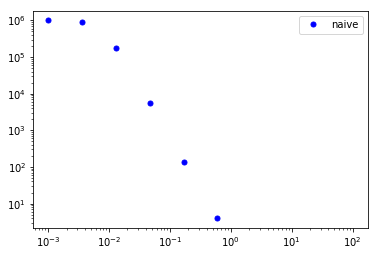

In [45]:
numerical_ceff_vals_3 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/3, 3, 'naive')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [numerical_ceff_vals_3], ['naive'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


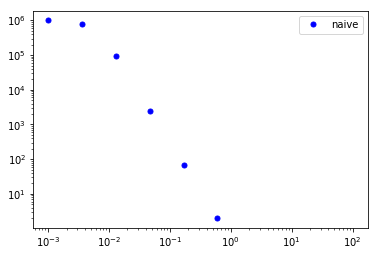

In [66]:
numerical_ceff_vals_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'naive')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [numerical_ceff_vals_4], ['naive'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


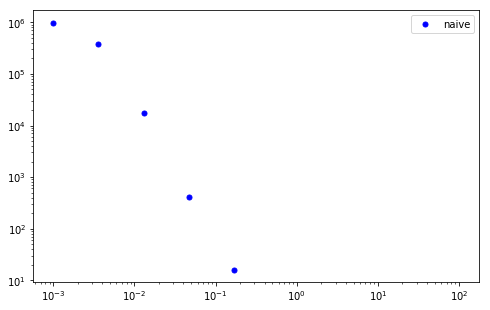

In [100]:
numerical_ceff_vals_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'naive')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [numerical_ceff_vals_7], ['naive'])

### Infinite sigma

In [126]:
def analytical_inf_sigma(n_links, k_min=0, k_max=100000, nbins=1000000, L=1):
    del_k = (k_max - k_min)/nbins
    k_vals = np.arange(k_min, k_max, del_k)
    ceff = 0
    for k in k_vals:
        ceff += k * (jv(0, k * L)**n_links) * del_k
    return ceff / (2 * np.pi) # Divide by 2 pi because this probability currently sums over all values of theta

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


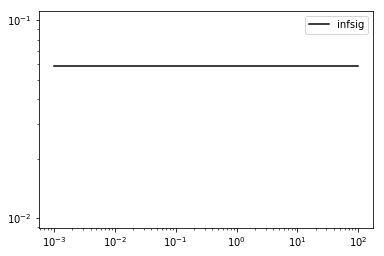

In [46]:
analytical_inf_vals_3 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/3, 3, 'infsig')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [analytical_inf_vals_3], ['infsig'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


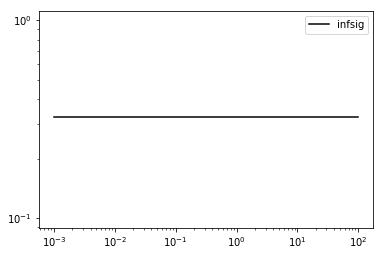

In [64]:
analytical_inf_vals_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'infsig')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [analytical_inf_vals_4], ['infsig'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


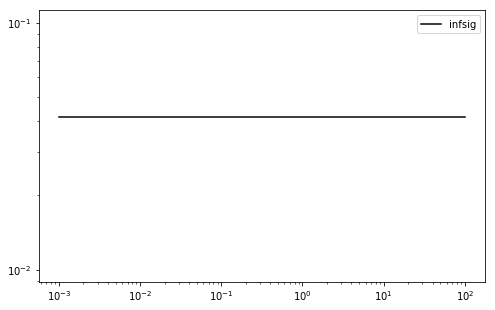

In [110]:
analytical_inf_vals_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'infsig')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [analytical_inf_vals_7], ['infsig'])

### Semi-analytical

In [47]:
def analytical_ceff_3(sigma):
    J = math.sqrt(3)/2
    ceff = 2 * np.pi * (eval_folded(sigma, 0)**3 + eval_folded(sigma, 2*np.pi/3)**3)/J
    return ceff

In [23]:
def old_analytical_ceff_4(sigma):
    theta_vals = np.arange(-np.pi, np.pi, np.pi/100)
    ceff = 0
    for theta in theta_vals:
        points0 = np.array([0, 0])
        points1 = np.array([math.cos(theta), math.sin(theta)])
        points2 = points1 + np.array([-1, 0])
        points3 = points2 + np.array([-math.cos(theta), -math.sin(theta)])
        points = [points0, points1, points2, points3]
        J = abs(get_J(points))
        ceff += (eval_folded(sigma, theta)**4) * 2 * np.pi/abs(np.cos(theta)) * np.pi/100 #J
    return ceff

In [48]:
def analytical_ceff_4(sigma):
    theta_vals = np.linspace(-np.pi, np.pi, 10000, endpoint=True)
    delta_theta = theta_vals[1] - theta_vals[0]
    folded_gauss_vals = eval_folded_grid(sigma, theta_vals)
    ceff = np.sum(folded_gauss_vals**4 * 2 * np.pi/np.abs(np.cos(theta_vals)) * delta_theta)
    return ceff

In [49]:
# This method does not scale to arbitrary n links
def analytical_ceff(sigma, n_links):
    if (n_links == 3):
        return analytical_ceff_3(sigma)
    if (n_links == 4):
        return analytical_ceff_4(sigma)
    else:
        print("Cannot compute analytical Ceff for nlinks not 3 or 4")
        return -1

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


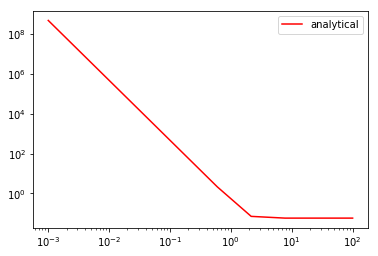

In [51]:
analytical_vals_3 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/3, 3, 'analytical')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [analytical_vals_3], ['analytical'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


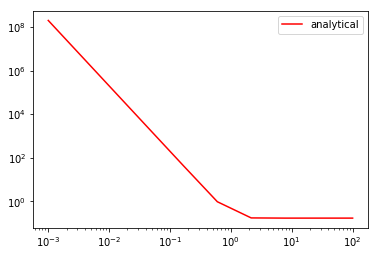

In [63]:
analytical_vals_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'analytical')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [analytical_vals_4], ['analytical'])

### Harmonic transform*

In [2]:
def compute_rhohat_mn(m, n, p, L, theta_0, sigma):
    return 1j**(n-m) * jv( m-n, p*L ) * np.exp(1j*n*theta_0 - (n*sigma)**2)

def compute_rhohat_matrix(p, L, theta_0, sigma, cutoff=10):
    rhohat_matrix = np.zeros([2*cutoff+1, 2*cutoff+1], dtype=complex)
    for i in range(rhohat_matrix.shape[0]):
        m = i - cutoff
        for j in range(rhohat_matrix.shape[1]):
            n = j - cutoff
            rhohat_matrix[i][j] = compute_rhohat_mn(m, n, p, L, theta_0, sigma)
            
    return rhohat_matrix

In [3]:
# populate an (m, n, p) matrix with all values of (m, n) rhohat matrices for various p's
def get_rhohat_ps(theta_0, sigma, L, cutoff, n_links, p_range):
    rhohat_all = np.zeros((p_range.shape[0], 2*cutoff+1, 2*cutoff+1), dtype=complex)
    for i_p, p in enumerate(p_range):
        rhohat = compute_rhohat_matrix(p, L, theta_0, sigma, cutoff)
        final_entry = np.identity(2*cutoff+1)
        for nl in range(n_links):
            final_entry = final_entry @ rhohat
        rhohat_all[i_p] = final_entry
    return rhohat_all

In [4]:
def se2_ceff(sigma, theta_0, n_links, L=1, cutoff=10, p_max=300, del_p=0.2):
    P   = np.arange(0, p_max, del_p)    
    m_n_range = 2*cutoff+1
    n_vals = np.arange(-cutoff, -cutoff+m_n_range)
    
    rhohat_all = get_rhohat_ps(theta_0, sigma, L, cutoff, n_links, P)
    
    prob_value = 0
    for m_idx in n_vals:
        prob_value += np.sum( rhohat_all[:, m_idx, m_idx] * P * del_p * jv(0, 0)/(4 * np.pi * np.pi) )
    return 2 * np.pi * np.real(prob_value)

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


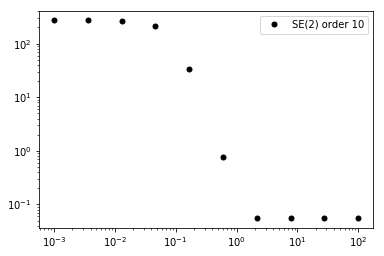

In [54]:
se2_ceff_vals_3 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/3, 3, 'SE(2) order 10')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [se2_ceff_vals_3], ['SE(2) order 10'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


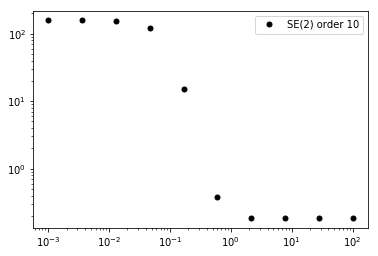

In [62]:
se2_ceff_vals_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'SE(2) order 10')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [se2_ceff_vals_4], ['SE(2) order 10'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


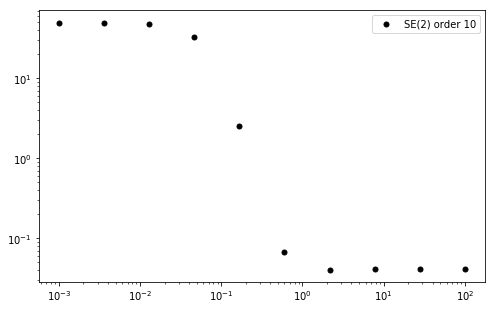

In [116]:
se2_ceff_vals_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'SE(2) order 10')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [se2_ceff_vals_7], ['SE(2) order 10'])

### Mining minima*

In [278]:
def mining_minima_explicit(sigma, n_links, cutoff=10000):
    if (n_links != 4):
        print("Explicit mining minima only implemented for 4 links")
        return 0

    theta_vals = 2 * np.pi * np.arange(-cutoff, cutoff)
    all_folded_gaussian_vals = np.exp(-theta_vals**2/(2 * sigma * sigma))
    Z = np.sum(all_folded_gaussian_vals)
    Z_unpaired = (Z/(math.sqrt(2 * np.pi) * sigma)) ** 4 # Z multiplied by normalization factor
    
    # Could instead approximate the Hessian numerically below
    dlogZ_dtheta2 = (1/Z) * (1/(sigma**2)) * (1 - np.sum(theta_vals**2 * all_folded_gaussian_vals)/(sigma**2))  
    if dlogZ_dtheta2 < 0:
        return 0 

    sigma_eff = 2/math.sqrt(dlogZ_dtheta2)
    Z_paired = math.sqrt(2 * np.pi) * sigma_eff * erf(np.pi/(math.sqrt(2) * sigma_eff)) 

    # Why are we multipying by Z_unpaired instead of dividing?
    # Not sure why I'm off by a factor of 4
    C_eff = 2 * np.pi * Z_unpaired * Z_paired/4
    return C_eff

In [ ]:
def mining_minima(sigma, n_links, cutoff=10000):

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


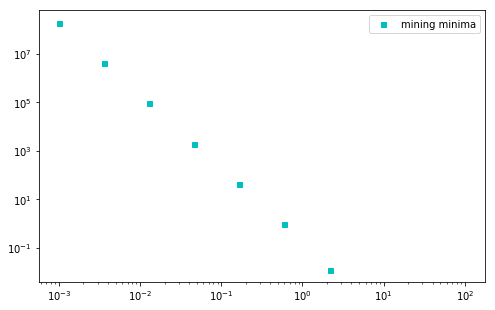

In [127]:
mining_minima_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'mining minima')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [mining_minima_4], ['mining minima'])

### Gaussian propagation

In [26]:
def gaussian_ceff(sigma, theta_0, n_links):
    start = np.array([[0, 0, 0], [0, 0, 0], [0, 0, sigma*sigma]]) # Covariance matrix
    rinv = np.array([[math.cos(theta_0), math.sin(theta_0), math.cos(theta_0)], \
        [-math.sin(theta_0), math.cos(theta_0), math.sin(theta_0)],[0, 0, 1]]) # Coordinate transform in SE2
    cur_mat = start
    for ii in range(n_links-1):
        cur_mat = np.matmul(np.matmul(rinv, cur_mat), rinv.transpose()) + start
    return 2 * np.pi/(math.sqrt(abs(np.linalg.det(cur_mat))) * (2 * np.pi)**(1.5))

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


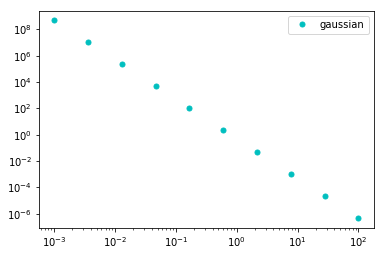

In [60]:
gaussian_ceff_3 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/3, 3, 'gaussian')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [gaussian_ceff_3], ['gaussian'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


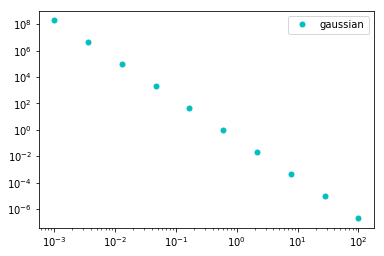

In [61]:
gaussian_ceff_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'gaussian')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [gaussian_ceff_4], ['gaussian'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


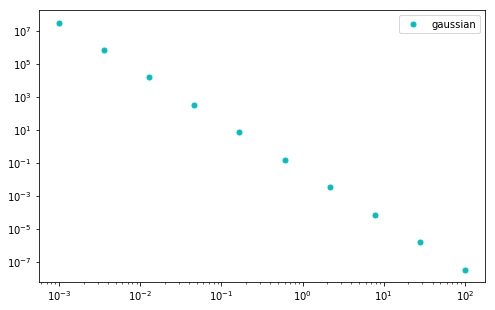

In [117]:
gaussian_ceff_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'gaussian')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [gaussian_ceff_7], ['gaussian'])

### Stochastic MC sampling*

In [69]:
def generate_for_samples(sigma, theta_0, nfor, L, niter):
    theta_totals = np.zeros(niter)
    x_totals = np.zeros(niter)
    y_totals = np.zeros(niter)
    for ii in range(nfor):
        theta_vals = np.random.normal(loc=theta_0, scale=sigma, size=niter)
        theta_totals += theta_vals
        theta_totals %= 2 * np.pi
        x_totals += L * np.cos(theta_totals)
        y_totals += L * np.sin(theta_totals)
    return [theta_totals, x_totals, y_totals]

In [70]:
def generate_rev_samples(sigma, theta_0, nrev, L, niter, add_noise=False):
    theta_rev_totals = np.zeros(niter)
    x_rev_totals = np.zeros(niter)
    y_rev_totals = np.zeros(niter)
    for ii in range(nrev):
        x_rev_totals -= L * np.cos(2 * np.pi - theta_rev_totals)
        if add_noise and nrev == 1:
            x_rev_totals += np.random.normal(loc=0, scale=0.001, size=niter)
        y_rev_totals -= L * np.sin(2 * np.pi - theta_rev_totals)
        if add_noise and nrev == 1:
            y_rev_totals += np.random.normal(loc=0, scale=0.001, size=niter)
        theta_vals = np.random.normal(loc=theta_0, scale=sigma, size=niter)
        theta_rev_totals += theta_vals
    theta_rev_totals = 2 * np.pi - theta_rev_totals
    theta_rev_totals %= 2 * np.pi
    return [theta_rev_totals, x_rev_totals, y_rev_totals]

In [71]:
def grid_ceff(sigma, theta_0, nfor, nrev, L=1, niter=100000, num_bins=400):
    # Generate forward samples
    [theta_totals, x_totals, y_totals] = generate_for_samples(sigma, theta_0, nfor, L, niter)

    # Generate reverse samples
    [theta_rev_totals, x_rev_totals, y_rev_totals] = generate_rev_samples(sigma, theta_0, nrev, L, niter)

    arr_data = np.concatenate(([theta_totals], [x_totals], [y_totals])).T
    rev_arr_data = np.concatenate(([theta_rev_totals], [x_rev_totals], [y_rev_totals])).T
    
    # Define x, y, theta bin dimensions for histogram
    del_theta = (2 * np.pi)/num_bins
    xmin = ymin = -2 * L
    xmax = ymax = 2 * L
    del_x = (xmax-xmin)/num_bins
    del_y = (ymax-ymin)/num_bins
    theta_bins = np.arange(0, 2 * np.pi, del_theta)
    x_bins = np.arange(xmin, xmax, del_x) - del_x/2
    y_bins = np.arange(ymin, ymax, del_y) - del_y/2

    # Assemble histogram using sampled values
    # density=True takes care of dividing by the total count and the bin volumes
    for_p_arr, _ = np.histogramdd(arr_data, bins=(theta_bins, x_bins, y_bins), density=True)
    rev_p_arr, _ = np.histogramdd(rev_arr_data, bins=(theta_bins, x_bins, y_bins), density=True)

    # Calculate the total probability of going forward and then backward
    for_rev_prod = np.multiply(for_p_arr, rev_p_arr)
    total = np.sum(for_rev_prod) * del_theta * del_x * del_y
    total *= 2 * np.pi
    return total

In [72]:
def grid_ceff_kde(sigma, theta_0, nfor, nrev, L=1, niter=1000, num_bins=400):
    # Generate forward samples
    [theta_totals, x_totals, y_totals] = generate_for_samples(sigma, theta_0, nfor, L, niter)

    # Generate reverse samples
    [theta_rev_totals, x_rev_totals, y_rev_totals] = generate_rev_samples(sigma, theta_0, nrev, L, niter, add_noise=True)

    arr_data = np.concatenate(([theta_totals], [x_totals], [y_totals]))
    rev_arr_data = np.concatenate(([theta_rev_totals], [x_rev_totals], [y_rev_totals]))

    # Use a Multivariable KDE to evaluate overlap
    for_kde = gaussian_kde(arr_data)
    rev_kde = gaussian_kde(rev_arr_data)

    # Calculate the total probability of going forward and then backward
    total = 2 * np.pi * for_kde.integrate_kde(rev_kde)    
    return total

In [67]:
style_dict.keys()

dict_keys(['analytical', 'infsig', 'gaussian', 'Last Link 1', 'Last Link 2', 'RNAMake', 'mining minima', 'grid1', 'grid2', 'grid1 kde', 'grid2 kde', 'SE(2) order 10', 'naive'])

In [76]:
grid1_ceff_3 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/3, 3, 'grid1')
grid1_ceff_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'grid1')
grid2_ceff_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'grid2')
grid1_ceff_kde_3 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/3, 3, 'grid1 kde')
grid1_ceff_kde_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'grid1 kde')
grid2_ceff_kde_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'grid2 kde')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.82559402207125

In [118]:
grid1_ceff_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'grid1')
grid2_ceff_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'grid2')
grid1_ceff_kde_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'grid1 kde')
grid2_ceff_kde_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'grid2 kde')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


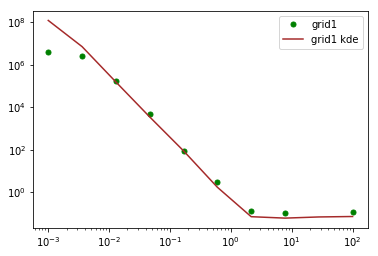

In [79]:
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [grid1_ceff_3, grid1_ceff_kde_3], ['grid1', 'grid1 kde'])

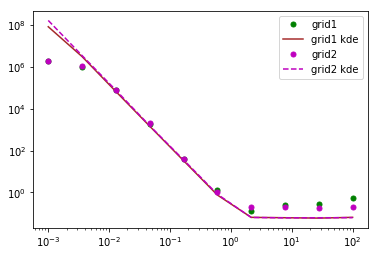

In [80]:
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [grid1_ceff_4, grid1_ceff_kde_4, grid2_ceff_4, grid2_ceff_kde_4], 
           ['grid1', 'grid1 kde', 'grid2', 'grid2 kde'])

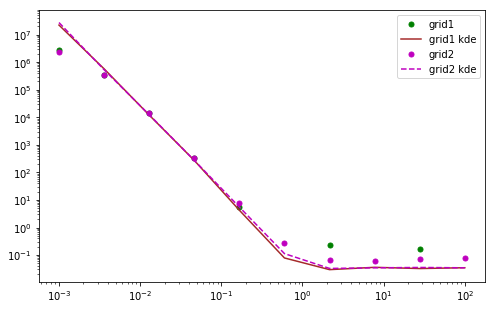

In [119]:
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [grid1_ceff_7, grid1_ceff_kde_7, grid2_ceff_7, grid2_ceff_kde_7], 
           ['grid1', 'grid1 kde', 'grid2', 'grid2 kde'])

### Last Link 1*

In [82]:
def last_link_1(sigma, theta_0, n_links, L=1, niter=10000, num_bins=10000, 
    r_thresh=0.01, theta_thresh=0.01):
    del_theta = 2 * np.pi/num_bins 

    theta_prod = np.ones(niter)

    # Sample first links
    [theta_totals, x_totals, y_totals] = generate_for_samples(sigma, theta_0, n_links-1, L, niter)

    # Last link
    theta_vals = 2 * np.pi - theta_totals
    folded_vals = eval_folded_grid(sigma, theta_vals - theta_0)

    # Indicator for length pass
    r_pass = np.abs(L - np.sqrt(x_totals**2 + y_totals**2)) < r_thresh
    r_pass = r_pass.astype(int)
    
    # Indicator for angle pass
    phi_final = np.arctan2(x_totals * np.sin(theta_totals) - y_totals * np.cos(theta_totals), \
        - x_totals * np.cos(theta_totals) - y_totals * np.sin(theta_totals))
    phi_pass = np.abs(theta_vals - phi_final) < theta_thresh
    phi_pass = phi_pass.astype(int)

    prob = sum(r_pass * folded_vals * phi_pass)/niter
    return 2 * np.pi * prob/(np.pi * r_thresh * theta_thresh)

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


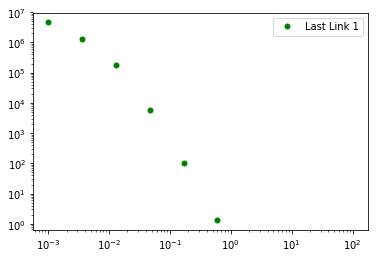

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


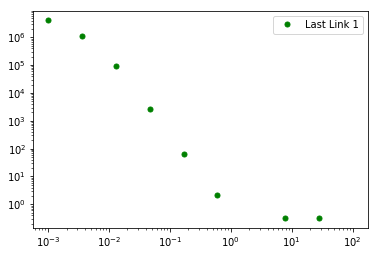

In [83]:
lastlink1_3 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/3, 3, 'Last Link 1')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [lastlink1_3], ['Last Link 1'])

In [ ]:
lastlink1_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'Last Link 1')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [lastlink1_4], ['Last Link 1'])

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


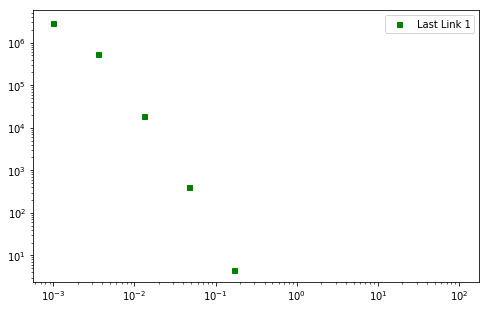

In [120]:
lastlink1_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'Last Link 1')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [lastlink1_7], ['Last Link 1'])

### Last Link 2*

In [144]:
def last_link_2_special(sigma, theta_0, n_links, L=1, niter=10000):
    if (n_links != 4):
        print("Cannot compute two last links' Ceff for nlinks not 4")
        return -1        
    
    # Get theta samples for one link
    theta_vals = np.random.normal(loc=theta_0, scale=sigma, size=niter)

    # For the one correct solution, calculate the area of the parallelopiped
    det_vals = np.abs(np.cos(theta_vals - theta_0))

    # Multiply by folded Gaussian values
    # Add all vals and multiply by 2 pi
    ceff = 2 * np.pi * np.sum(eval_folded_grid(sigma, theta_vals - theta_0)**3/det_vals)/niter
    return ceff

In [199]:
def generate_last_two_samples(sigma, theta_0, nfor, L, niter):
    theta_totals = np.zeros(niter)
    x_totals = np.zeros(niter)
    y_totals = np.zeros(niter)
    x_prev = np.zeros(niter)
    y_prev = np.zeros(niter)
    for ii in range(nfor):
        theta_vals = np.random.normal(loc=theta_0, scale=sigma, size=niter)
        theta_totals += theta_vals
        theta_totals %= 2 * np.pi
        x_prev = np.copy(x_totals)
        y_prev = np.copy(y_totals)
        x_totals += L * np.cos(theta_totals)
        y_totals += L * np.sin(theta_totals)
    return [theta_totals, x_totals, y_totals, x_prev, y_prev]

In [274]:
def last_link_2(sigma, theta_0, n_links, L=1, niter=10000):
    if (n_links < 4):
        print("Cannot compute two last links' Ceff for nlinks less than 4")
        return -1        
    
    # Get theta samples for one link
    [theta_totals, x_totals, y_totals, x_prev, y_prev] = \
        generate_last_two_samples(sigma, theta_0, n_links - 3, L, niter)
    
    # Get remaining points
    [(x1, y1), (x2, y2)] = get_triangles(x_totals, y_totals, L)
    
    # Get angles for probability calculation
    zeros = np.zeros(niter)
    angle1_1 = np.pi - get_angle([x_prev, y_prev], [x_totals, y_totals], [x1, y1])
    angle1_2 = np.pi - get_angle([x_prev, y_prev], [x_totals, y_totals], [x2, y2])
    angle2_1 = np.pi - get_angle([x_totals, y_totals], [x1, y1], [-L * np.ones(niter), zeros])
    angle2_2 = np.pi - get_angle([x_totals, y_totals], [x2, y2], [-L * np.ones(niter), zeros])
    angle3_1 = np.pi - get_angle([x1, y1], [-L * np.ones(niter), zeros], [zeros, zeros])
    angle3_2 = np.pi - get_angle([x2, y2], [-L * np.ones(niter), zeros], [zeros, zeros])

    # Vectorized determinant calculation 
    det_vals_1 = np.abs(get_J([[x_totals, y_totals], [x1, y1], [-L * np.ones(niter), zeros]]))
    det_vals_2 = np.abs(get_J([[x_totals, y_totals], [x2, y2], [-L * np.ones(niter), zeros]]))

    # Evaluate probability value with folded Gaussians
    soln_1 = np.nansum(eval_folded_grid(sigma, angle1_1 - theta_0) * \
                eval_folded_grid(sigma, angle2_1 - theta_0) * \
                eval_folded_grid(sigma, angle3_1 - theta_0)/det_vals_1)
    soln_2 = np.nansum(eval_folded_grid(sigma, angle1_2 - theta_0) * \
                eval_folded_grid(sigma, angle2_2 - theta_0) * \
                eval_folded_grid(sigma, angle3_2 - theta_0)/det_vals_2)

    # Add all vals and multiply by 2 pi
    ceff = 2 * np.pi * (soln_1 + soln_2)/niter
    return ceff

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


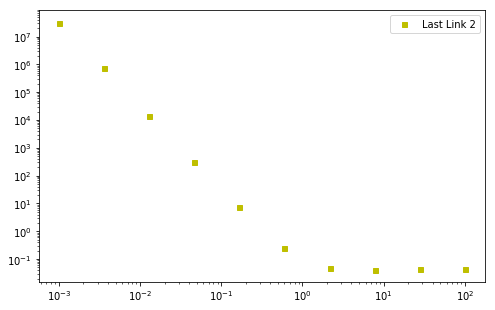

In [276]:
lastlink2_7 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, 2 * np.pi/7, 7, 'Last Link 2')
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [lastlink2_7], ['Last Link 2'])

In [237]:
lastlink2_4 = eval_ceff_range(SIGMA_MIN, SIGMA_MAX, NUM_PTS, np.pi/2, 4, 'Last Link 2')

0.001
203352073.13675562
0.003593813663804626
4284138.373971814
0.01291549665014884
91878.07972388242
0.046415888336127795
2004.038286039811
0.1668100537200059
42.90091341304131
0.5994842503189409
0.979109403622344
2.1544346900318843
0.4058709611406786
7.742636826811277
0.8393209577172632
27.825594022071257
0.2854118055096399
100.0
0.30246138742429535


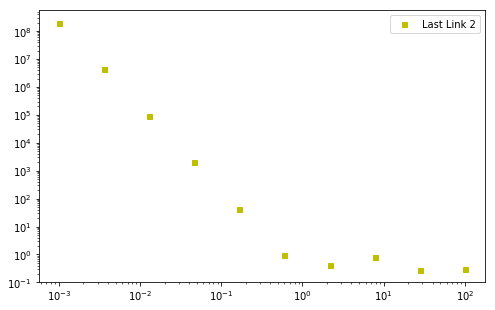

In [240]:
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, [lastlink2_4], ['Last Link 2'])

## Comparing Ceff methods

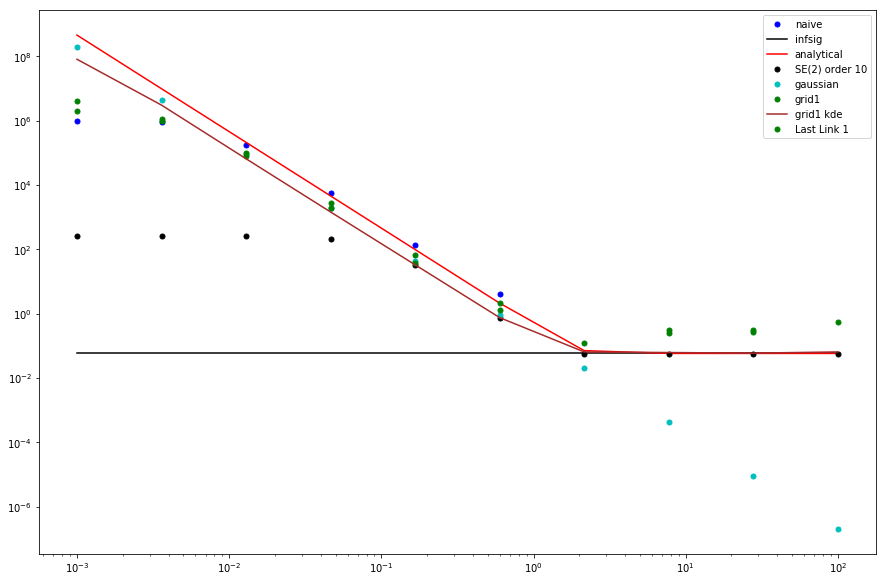

In [95]:
# Three links
ceff_lists_3 = [numerical_ceff_vals_3, analytical_inf_vals_3, analytical_vals_3, se2_ceff_vals_3, \
                gaussian_ceff_4, grid1_ceff_4, grid1_ceff_kde_4, lastlink1_4]
label_list_3 = ['naive', 'infsig', 'analytical', 'SE(2) order 10', 'gaussian',\
                'grid1', 'grid1 kde', 'Last Link 1']
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, ceff_lists_3, label_list_3, fig_size=(15, 10))

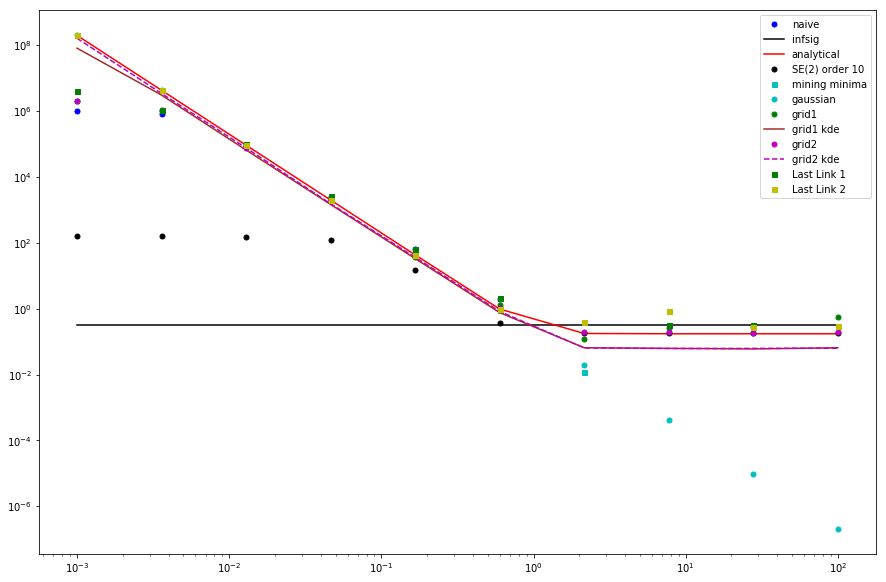

In [239]:
# Four links
ceff_lists_4 = [numerical_ceff_vals_4, analytical_inf_vals_4, analytical_vals_4, se2_ceff_vals_4, \
                mining_minima_4, gaussian_ceff_4, grid1_ceff_4, grid1_ceff_kde_4, grid2_ceff_4, \
                grid2_ceff_kde_4, lastlink1_4, lastlink2_4]
label_list_4 = ['naive', 'infsig', 'analytical', 'SE(2) order 10', 'mining minima', 'gaussian',\
                'grid1', 'grid1 kde', 'grid2', 'grid2 kde', 'Last Link 1', 'Last Link 2']
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, ceff_lists_4, label_list_4, fig_size=(15, 10))

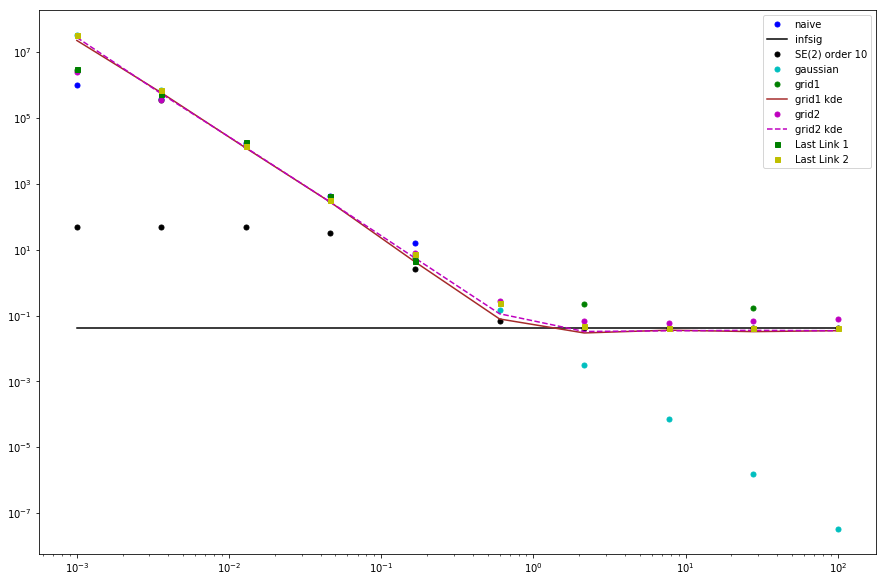

In [277]:
# Seven links
ceff_lists_7 = [numerical_ceff_vals_7, analytical_inf_vals_7, se2_ceff_vals_7, \
                gaussian_ceff_7, grid1_ceff_7, grid1_ceff_kde_7, grid2_ceff_7, \
                grid2_ceff_kde_7, lastlink1_7, lastlink2_7]
label_list_7 = ['naive', 'infsig', 'SE(2) order 10', 'gaussian',\
                'grid1', 'grid1 kde', 'grid2', 'grid2 kde', 'Last Link 1', 'Last Link 2']
plot_ceffs(SIGMA_MIN, SIGMA_MAX, NUM_PTS, ceff_lists_7, label_list_7, fig_size=(15, 10))